In [1]:
import pandas as pd
import networkx as nx

from tqdm import tqdm
from scipy import stats

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/window-actor-corrs.json/'))))

9555it [00:00, 319279.29it/s]


In [4]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

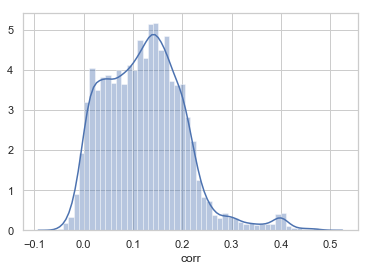

In [12]:
sns.distplot(df['corr'])

In [5]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [6]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf['corr'])
    rows.append((d1, d2, lr.slope, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:00<00:00, 310.66it/s]


In [7]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'p', 'r'))

In [8]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

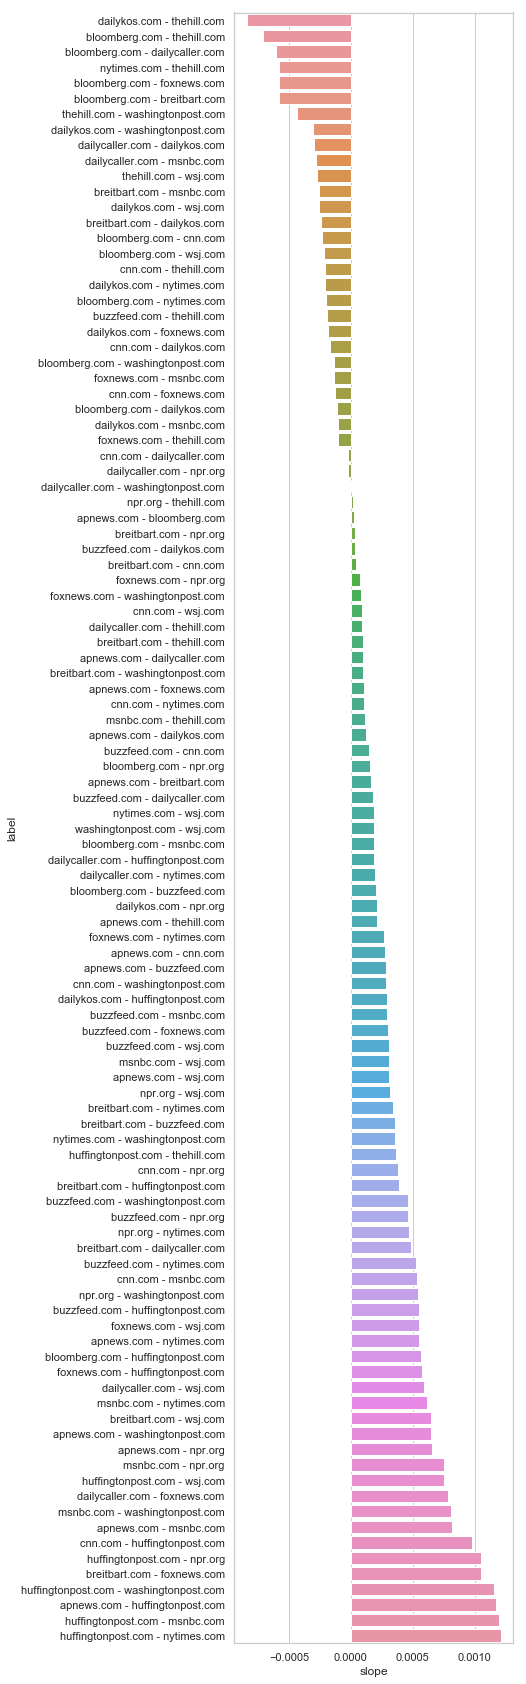

In [9]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [13]:
def plot_pair(d1, d2):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    plt.figure(figsize=(3,2))
    plt.ylim(-0.2,0.5)
    sns.lineplot(x='window', y='corr', data=pdf)
    plt.show()

huffingtonpost.com nytimes.com 1.4831873205438485e-22


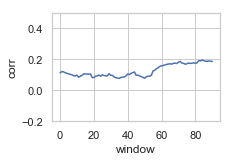

huffingtonpost.com msnbc.com 6.003161435040384e-25


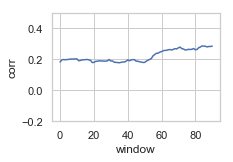

apnews.com huffingtonpost.com 1.2294876304535696e-27


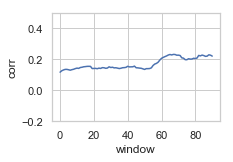

huffingtonpost.com washingtonpost.com 6.19235266844444e-23


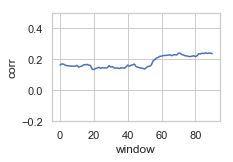

breitbart.com foxnews.com 2.6231379228712174e-35


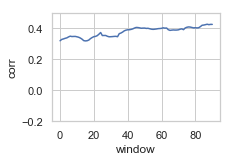

huffingtonpost.com npr.org 2.832478871455471e-23


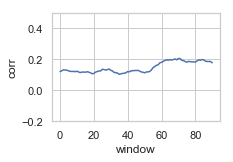

cnn.com huffingtonpost.com 1.0127653888584309e-24


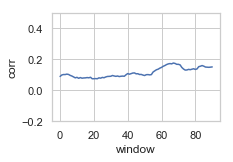

apnews.com msnbc.com 1.4072694646191591e-19


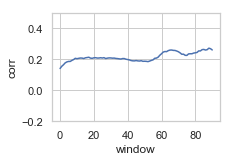

msnbc.com washingtonpost.com 3.2388565482567765e-29


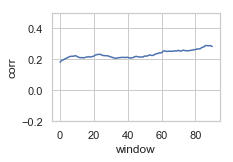

dailycaller.com foxnews.com 1.7664139025453995e-10


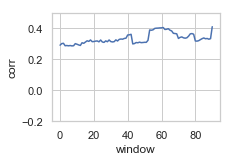

In [15]:
for r in lr_df.sort_values('slope', ascending=False).head(10).itertuples():
    print(r.d1, r.d2, r.p)
    plot_pair(r.d1, r.d2)

dailykos.com thehill.com 1.658461084682673e-26


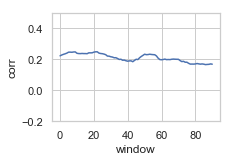

bloomberg.com thehill.com 1.4361165887407176e-17


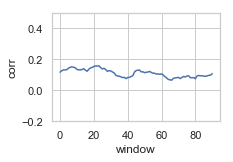

bloomberg.com dailycaller.com 6.633893458081302e-20


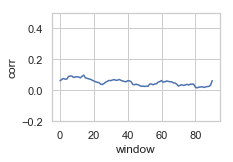

nytimes.com thehill.com 4.823019475481187e-10


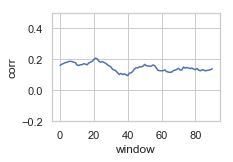

bloomberg.com foxnews.com 6.785305152208694e-27


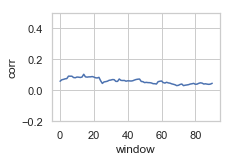

bloomberg.com breitbart.com 3.0930944410697724e-19


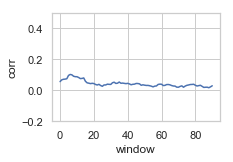

thehill.com washingtonpost.com 8.064840870313193e-07


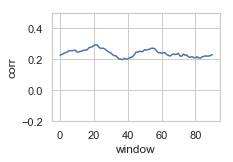

dailykos.com washingtonpost.com 1.3946337270735575e-14


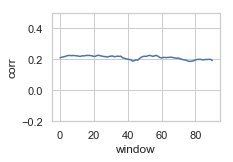

dailycaller.com dailykos.com 2.2717528942874467e-10


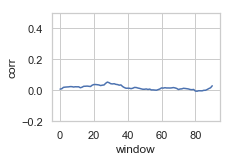

dailycaller.com msnbc.com 2.2975537404346737e-06


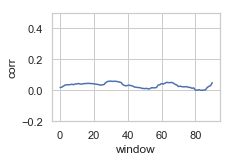

In [17]:
for r in lr_df.sort_values('slope', ascending=True).head(10).itertuples():
    print(r.d1, r.d2, r.p)
    plot_pair(r.d1, r.d2)

In [14]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s < 0 else 'blue')
lr_df['width'] = abs(lr_df.slope*2000)**2

In [15]:
g = nx.Graph()
for r in lr_df.itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [16]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


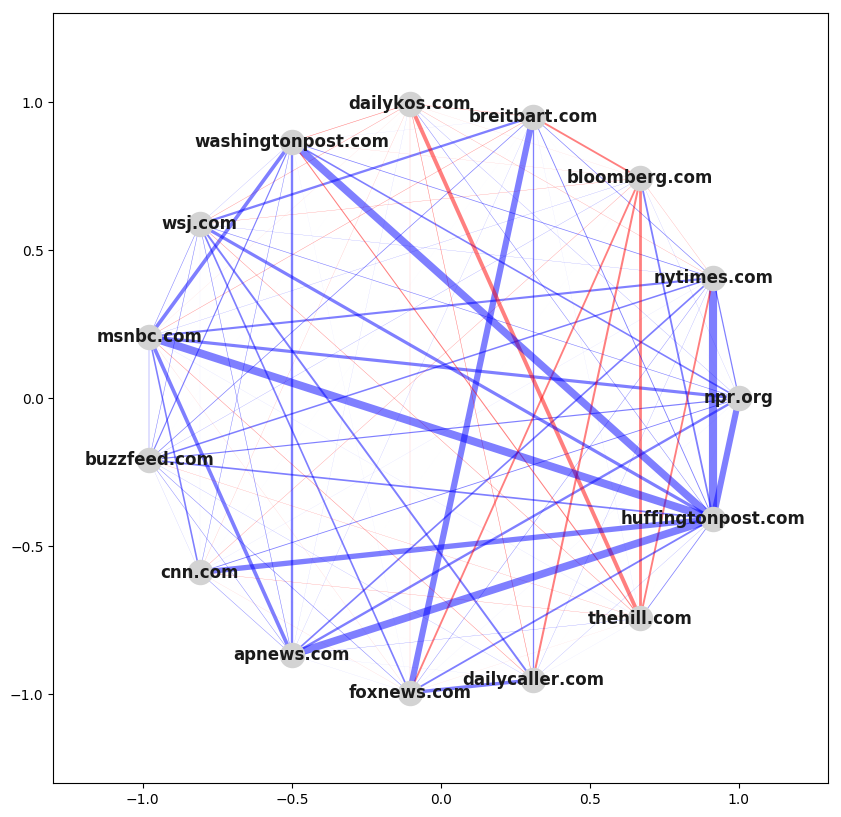

In [17]:
mpl.style.use('default')
plt.figure(figsize=(10,10))
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')